<h1 style="text-align: center;"> Учебно-исследовательская работа по теме <br>"Разработка решения для сегментации изображений <br> на экран и окружающую область"</h1>

<h2><b>Подготовка инструментов выполнения</b></h2>

 <h3><b>1. Установка зависимостей</b></h3>

In [ ]:
%%capture
%pip install tensorflow==2.10.0 numpy==1.24.2 pandas==2.2.1 matplotlib==3.8.0 Pillow==10.1.0 albumentations==2.0.5 pycocotools==2.0.8 roboflow==1.1.55 segmentation-models==1.0.1

<h3><b>2. Импорт библиотек и проверка оборудования</b></h3>

In [31]:
import tensorflow as tf
import os
import json
import numpy as np
import pandas as pd
import albumentations as A
import segmentation_models as sm
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from roboflow import Roboflow
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

In [ ]:
# Проверка GPU
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Найдено {len(gpus)} GPU:")
    for gpu in gpus:
        print(f" - {gpu}")
        tf.config.experimental.set_memory_growth(gpu, True)  # Динамическое выделение памяти
else:
    raise RuntimeError("GPU не найдено! Проверьте установку CUDA 11.2 и cuDNN 8.1.")

# # Мixed precision для ускорения ( в моем случае ломает функцию потерь)
# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

<h2><b>Обработка датасета</b></h2>
В этом разделе мы подготовим датасет для обучения модели в формате <b>COCO</b> для <b>TensorFlow</b>.
<h3><b>1. Загрузка данных</b></h3>

Для поиска датасета воспользуемся ресурсом датасетов "<a href="https://universe.roboflow.com">Roboflow</a>".


Теперь используем Roboflow для загрузки нужного датасета в формате COCO (в директории должна создаться папка "Screen-segmentation-3"):

In [ ]:
rf = Roboflow(api_key="to3YrOBj0FlHoBjF9Vwn")
project = rf.workspace("uit-kbay3").project("screen-segmentation")
version = project.version(3)
dataset = version.download("coco-segmentation")
                


В папке датасет уже разделён на выборки train и test. Как правило, в машинном обучении выборка разбивается на два набора:
- **Train (обучающая выборка)** – используется для обновления весов модели.
- **Test (тестовая выборка)** – используется только после обучения на данных, которые модель не видела - на основе результатов строит оценка модели.


Такое разбиение необходимо, чтобы убедиться, что модель не просто запомнила тренировочные данные, а действительно способна правильно сегментировать новые изображения.


<h3><b>2. Определение путей и гиперпараметров</b></h3>

Гиперпараметры - это параметры, которые задаются перед началом обучения модели и оказывают значительное влияние на процесс обучения:
- `IMG_SIZE` - размер входных изображений. Чем больше размер, тем больше информации сохраняется, но выше требования к памяти.
- `BATCH_SIZE` - количество изображений, подаваемых в модель за одну итерацию. Оптимально выбирать в зависимости от доступной памяти GPU.
- `EPOCHS` - количество эпох (проходов через весь датасет). Большее количество эпох может улучшить результаты, но увеличивает время тренировки.
- `FREEZE_ENCODER` - заморозка слоев энкодера. если данных недостаточно, мы можем заморозить веса энкодера, чтобы использовать его как фиксированное представление признаков, что помогает избежать переобучения модели
- `LEARNING_RATE` - шаг градиентного спуска или скорость обучения, которая определяет, насколько сильно обновляются веса модели на каждой итерации оптимизации. Маленькое значение может привести к медленной сходимости, а слишком большое — к нестабильному обучению или пропуску оптимального решения.

Запишем гиперпарметры в переменные:

In [34]:
IMG_SIZE = 384  # Размер входных изображений
BATCH_SIZE = 4  # Размер батча
EPOCHS = 5  # Количество эпох обучения (чем больше, тем лучше, но дольше)
FREEZE_ENCODER = True  # Заморозить энкодер, если данных мало (< 10000 изображений)
LEARNING_RATE = 1e-4
NUM_CLASSES = 1  # Количество классов (фон + объект)


Перед началом работы с датасетом заведём отдельную переменную под хранение путей к файлам датасета. Для этого напишем следующее:

In [35]:
# Пути к данным
DATASET_PATH = "./Screen-segmentation-3"
TRAIN_PATH = DATASET_PATH + "/train/"
TEST_PATH = DATASET_PATH + "/test/"
TRAIN_JSON = TRAIN_PATH + "_annotations.coco.json" 
TEST_JSON = TEST_PATH + "_annotations.coco.json"   

# Проверка существования путей к данным
print("Проверка путей:")
print("Train JSON path:", os.path.exists(TRAIN_JSON))
print("Test JSON path:", os.path.exists(TEST_JSON))
print("Train folder path:", os.path.exists(TRAIN_PATH))
print("Test folder path:", os.path.exists(TEST_PATH))

Проверка путей:
Train JSON path: True
Test JSON path: True
Train folder path: True
Test folder path: True


<h3><b>3. Процесс аугментации</b></h3>

In [36]:
# Определяем аугментации с помощью albumentations
augment = A.Compose([
    A.HorizontalFlip(p=0.45),  # Горизонтальное отражение с вероятностью 45%
    A.VerticalFlip(p=0.55),  # Вертикальное отражение с вероятностью 55%
    A.GaussianBlur(p=0.25),  # Добавляем Blur 25%
    A.GaussNoise(p=0.5)  # Добавляем Шум 50%
])

# Функция аугментации
def augment_fn(image, mask):
    # Преобразуем тензоры в NumPy и приводим к формату albumentations
    image_np = (image.numpy() * 255).astype(np.float32)  # Из [0, 1] в [0, 255]
    mask_np = mask.numpy()[..., 0] 
    
    # Применяем аугментацию
    augmented = augment(image=image_np, mask=mask_np)
    
    # Возвращаем обратно в тензоры
    image_aug = tf.convert_to_tensor(augmented['image'], dtype=tf.float32) / 255.0
    mask_aug = tf.convert_to_tensor(augmented['mask'], dtype=tf.float32)[..., tf.newaxis]  # Добавляем канал здесь
    
    return image_aug, mask_aug

<h3><b>4. Функция загрузки и обработки данных COCO</b></h3>

Далее мы приступаем к подготовке данных для обучения модели. Для этого используем формат COCO. 



In [37]:
# Функция для загрузки и обработки данных COCO

def load_and_process_coco(json_path, img_dir):
    coco = COCO(json_path)
    img_ids = coco.getImgIds()
    print(f"Found {len(img_ids)} images in {json_path}")
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        try:
            image = Image.open(img_path).convert('RGB')
            image = np.array(image, dtype=np.float32) / 255.0  # Нормализация в [0, 1]
            ann_ids = coco.getAnnIds(imgIds=img_id)
            anns = coco.loadAnns(ann_ids)
            # Инициализируем маску как uint8 для побитовых операций
            mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
            for ann in anns:
                if 'segmentation' in ann:
                    # Выполняем побитовую операцию с uint8
                    mask |= coco.annToMask(ann)  # coco.annToMask возвращает uint8
            # После сборки маски преобразуем в float32 для обучения
            mask = mask.astype(np.float32)
            image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
            image = tf.clip_by_value(image, 0, 1)
            mask = tf.image.resize(mask[..., np.newaxis], (IMG_SIZE, IMG_SIZE), method='nearest')
            mask = tf.clip_by_value(mask, 0, 1)
            image.set_shape([IMG_SIZE, IMG_SIZE, 3])
            mask.set_shape([IMG_SIZE, IMG_SIZE, 1])
            yield image, mask
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            continue
        

        # Создаём датасеты
train_dataset = tf.data.Dataset.from_generator(
    lambda: load_and_process_coco(TRAIN_JSON, TRAIN_PATH),
    output_types=(tf.float32, tf.float32),
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [IMG_SIZE, IMG_SIZE, 1])
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: load_and_process_coco(TEST_JSON, TEST_PATH),
    output_types=(tf.float32, tf.float32),
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [IMG_SIZE, IMG_SIZE, 1])
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



print("Датасеты успешно созданы!")

Датасеты успешно созданы!


In [ ]:
# Проверка датасетов

# Проверка train_dataset
for image_batch, mask_batch in train_dataset.take(1):
    print("Train dataset:")
    print("Images shape:", image_batch.shape)
    print("Masks shape:", mask_batch.shape)
    print("Images min/max:", tf.reduce_min(image_batch), tf.reduce_max(image_batch))
    print("Masks min/max:", tf.reduce_min(mask_batch), tf.reduce_max(mask_batch))

# Проверка test_dataset
for image_batch, mask_batch in test_dataset.take(1):
    print("\nTest dataset:")
    print("Images shape:", image_batch.shape)
    print("Masks shape:", mask_batch.shape)
    print("Images min/max:", tf.reduce_min(image_batch), tf.reduce_max(image_batch))
    print("Masks min/max:", tf.reduce_min(mask_batch), tf.reduce_max(mask_batch))
for images, masks in train_dataset.take(1):
    print("Images has NaN:", tf.reduce_any(tf.math.is_nan(images)))
    print("Masks has NaN:", tf.reduce_any(tf.math.is_nan(masks)))
    print("Images min/max:", tf.reduce_min(images), tf.reduce_max(images))
    print("Masks min/max:", tf.reduce_min(masks), tf.reduce_max(masks))
    print("Unique mask values:", tf.unique(tf.reshape(masks, [-1])).y.numpy())


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 807 images in ./Screen-segmentation-3/train/_annotations.coco.json


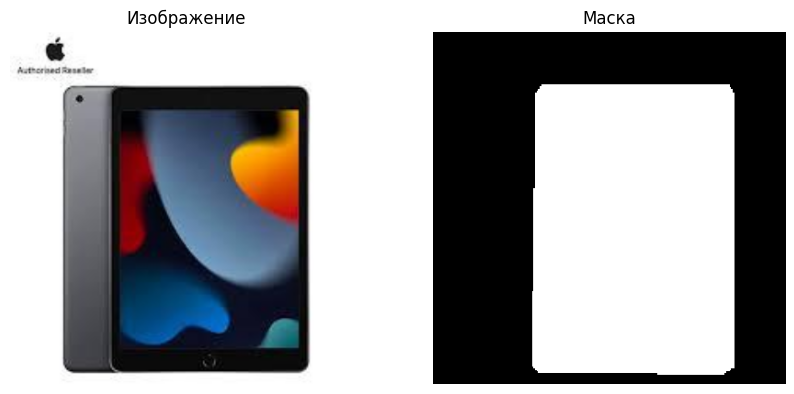

In [39]:
# Визуализация одного примера из датасета
def visualize_sample(image, mask):
    plt.figure(figsize=(10, 5))
    
    # Изображение
    plt.subplot(1, 2, 1)
    plt.title("Изображение")
    plt.imshow(image)
    plt.axis('off')
    
    # Маска
    plt.subplot(1, 2, 2)
    plt.title("Маска")
    plt.imshow(mask[..., 0], cmap='gray')
    plt.axis('off')
    
    plt.show()

# Берём один батч и визуализируем первый элемент
for image_batch, mask_batch in train_dataset.take(1):
    visualize_sample(image_batch[0], mask_batch[0])

<h3><b>5. Создание, компиляция моделей и сохранение результатов</b></h3>

Теперь мы создадим модели U-Net, используя предобученные модели.  Также мы используем dice_loss как функцию потерь, так как это задача бинарной сегментации (каждый пиксель принадлежит или не принадлежит объекту).

Метрика accuracy и IoU позволит отслеживать точность классификации.

In [41]:
# Указываем backend перед импортом segmentation_models
os.environ['SM_FRAMEWORK'] = "tf.keras"
dice_loss = sm.losses.DiceLoss() # Dice loss
iou_score = sm.metrics.IOUScore()  # IoU metric

# Temporary folder for results and predictions
os.makedirs("temp_results", exist_ok=True)
os.makedirs("temp_results/predictions", exist_ok=True)  # Папка для сохранения предсказаний

# Функция для наложения маски на изображение
def overlay_mask(image, mask, color=(255, 0, 0), alpha=0.4):
    """
    Накладывает маску на изображение с заданным цветом и прозрачностью.
    image: numpy массив [H, W, 3], значения в [0, 1]
    mask: numpy массив [H, W, 1] или [H, W], значения в [0, 1]
    color: кортеж (R, G, B)
    alpha: прозрачность маски
    """
    image = (image * 255).astype(np.uint8)  # Преобразуем обратно в [0, 255]
    mask = (mask > 0.5).astype(np.uint8)  # Бинаризуем маску по порогу 0.5
    overlay = image.copy()
    for c in range(3):
        overlay[:, :, c] = np.where(mask.squeeze(), 
                                    (1 - alpha) * image[:, :, c] + alpha * color[c], 
                                    image[:, :, c])
    return overlay

# Функция для сохранения предсказанных масок
def save_predicted_masks(model, dataset, experiment_name, num_samples):
    """
    Сохраняет предсказанные маски для первых num_samples изображений из тестового набора.
    """
    output_dir = f"temp_results/predictions/{experiment_name}"
    os.makedirs(output_dir, exist_ok=True)
    
    for i, (image_batch, _) in enumerate(dataset.take(num_samples)):
        predictions = model.predict(image_batch)  # Предсказание масок
        for j in range(image_batch.shape[0]):
            image = image_batch[j].numpy()
            pred_mask = predictions[j]
            result_image = overlay_mask(image, pred_mask)
            result_image = Image.fromarray(result_image)
            result_image.save(f"{output_dir}/test_image_{i * BATCH_SIZE + j}.png")
    print(f"Predictions saved to {output_dir}")


# Function for training and saving results
def train_and_evaluate(backbone, weights, model_fn, experiment_name):
    print(f"Training model: {experiment_name}")
    
    # Model creation
    with tf.device('/GPU:0'):
        model = model_fn(
            backbone_name=backbone,
            encoder_weights='imagenet',
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            classes=NUM_CLASSES,
            activation='sigmoid',
            encoder_freeze=FREEZE_ENCODER)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0),
            loss=dice_loss,
            metrics=['accuracy', iou_score]
        )
        model.summary()
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_iou_score', patience=10, mode='max', restore_best_weights=True)
    checkpoint = ModelCheckpoint(f"models/best_model_{experiment_name}.h5", monitor='val_iou_score', save_best_only=True, mode='max')
    
    # Training on GPU
    with tf.device('/GPU:0'):
        start_time = time.time()
        history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=test_dataset,
            callbacks=[early_stopping, checkpoint],
            verbose=1
        )
    total_time = time.time() - start_time
    
    # Calculate metrics
    mean_iou = np.mean(history.history['val_iou_score'])
    best_iou = np.max(history.history['val_iou_score'])
    mean_accuracy = np.mean(history.history['val_accuracy'])
    best_accuracy = np.max(history.history['val_accuracy'])
    best_loss = np.min(history.history['val_loss'])
    mean_time_per_epoch = total_time / len(history.history['loss'])
    
    # Form the results table
    data = {
        "Network Configuration": [experiment_name],
        "Mean IoU": [mean_iou],
        "Best IoU": [best_iou],
        "Mean Pixel Accuracy (test)": [mean_accuracy],
        "Best Pixel Accuracy (test)": [best_accuracy],
        "Best Loss (test)": [best_loss],
        "Mean Time per Epoch (s)": [mean_time_per_epoch],
        "Total Training Time (s)": [total_time]
    }
    df = pd.DataFrame(data)
    df.to_csv(f"temp_results/tables/results_{experiment_name}.csv", index=False)
    
    # Plotting graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.legend()
    plt.title('Dice Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Pixel Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Pixel Accuracy')
    plt.legend()
    plt.title('Pixel Accuracy')
    plt.savefig(f"temp_results/plots/plot_{experiment_name}.png")
    plt.close()
    
    # Save predicted masks for test dataset
    save_predicted_masks(model, test_dataset, experiment_name, num_samples=10)
    
    return model, history



<h3><b>7. Обучение модели</b></h3>

Теперь тренируем модель на подготовленных данных.


In [ ]:
# Список моделей для экспериментов
backbones = [
    ("resnet50", "imagenet", sm.Unet),
    ("mobilenetv2", "imagenet", sm.Unet),
    ("efficientnetb0", "imagenet", sm.Unet)
    ("efficientnetb3", "imagenet", sm.Unet),
    ("inceptionv3", "imagenet", sm.Unet)
]
# Запуск экспериментов
results = []
for backbone, weights, model_fn in backbones:
    experiment_name = f"{model_fn.__name__}_{backbone}_{weights}"
    model, history = train_and_evaluate(backbone, weights, model_fn, experiment_name)
    results.append((experiment_name, model, history))
for experiment_name, _, _ in results:
    df = pd.read_csv(f"temp_results/tables/results_{experiment_name}.csv")
    print(f"\nResults for {experiment_name}:")
    print(df)

<h3><b>8. Результаты</b></h3>

Для оценки эффективности построим таблицу

In [62]:
    df1 = pd.read_csv(f"temp_results/tables/NOAUGresults_{experiment_name}.csv")
    print(f"\nРезультаты для {experiment_name} без аугментирования:")
    print(df1)
    df2 = pd.read_csv(f"temp_results/tables/AUGresults_{experiment_name}.csv")
    print(f"\nРезультаты для {experiment_name} с аугментированием:")
    print(df2)
    df3 = pd.read_csv(f"temp_results/tables/5EPOCHSresults_{experiment_name}.csv")
    print(f"\nРезультаты для {experiment_name} с 5 эпохами:")
    print(df3)
    df4 = pd.read_csv(f"temp_results/tables/NOAUGresults_{experiment_name}.csv")
    print(f"\nРезультаты для {experiment_name} с 20 эпохами:")
    print(df4)
    df5 = pd.read_csv(f"temp_results/tables/6BATCHresults_{experiment_name}.csv")
    print(f"\nРезультаты для {experiment_name} с размером батча 6:")
    print(df5)
    df6 = pd.read_csv(f"temp_results/tables/2BATCHresults_{experiment_name}.csv")
    print(f"\nРезультаты для {experiment_name} с размером батча 2:")
    print(df6)


Результаты для Unet_mobilenetv2_imagenet без аугментирования:
       Network Configuration  Mean IoU  Best IoU  Mean Pixel Accuracy (test)  \
0  Unet_mobilenetv2_imagenet  0.870571  0.902028                    0.956979   

   Best Pixel Accuracy (test)  Best Loss (test)  Mean Time per Epoch (s)  \
0                    0.966006          0.052315                36.857431   

   Total Training Time (s)  
0                737.14862  

Результаты для Unet_mobilenetv2_imagenet с аугментированием:
       Network Configuration  Mean IoU  Best IoU  Mean Pixel Accuracy (test)  \
0  Unet_mobilenetv2_imagenet  0.869925  0.911402                    0.957712   

   Best Pixel Accuracy (test)  Best Loss (test)  Mean Time per Epoch (s)  \
0                    0.968065          0.047285                36.215103   

   Total Training Time (s)  
0               724.302056  

Результаты для Unet_mobilenetv2_imagenet с 5 эпохами:
       Network Configuration  Mean IoU  Best IoU  Mean Pixel Accuracy (test)

Расположим точки на оси для всех экспериментов

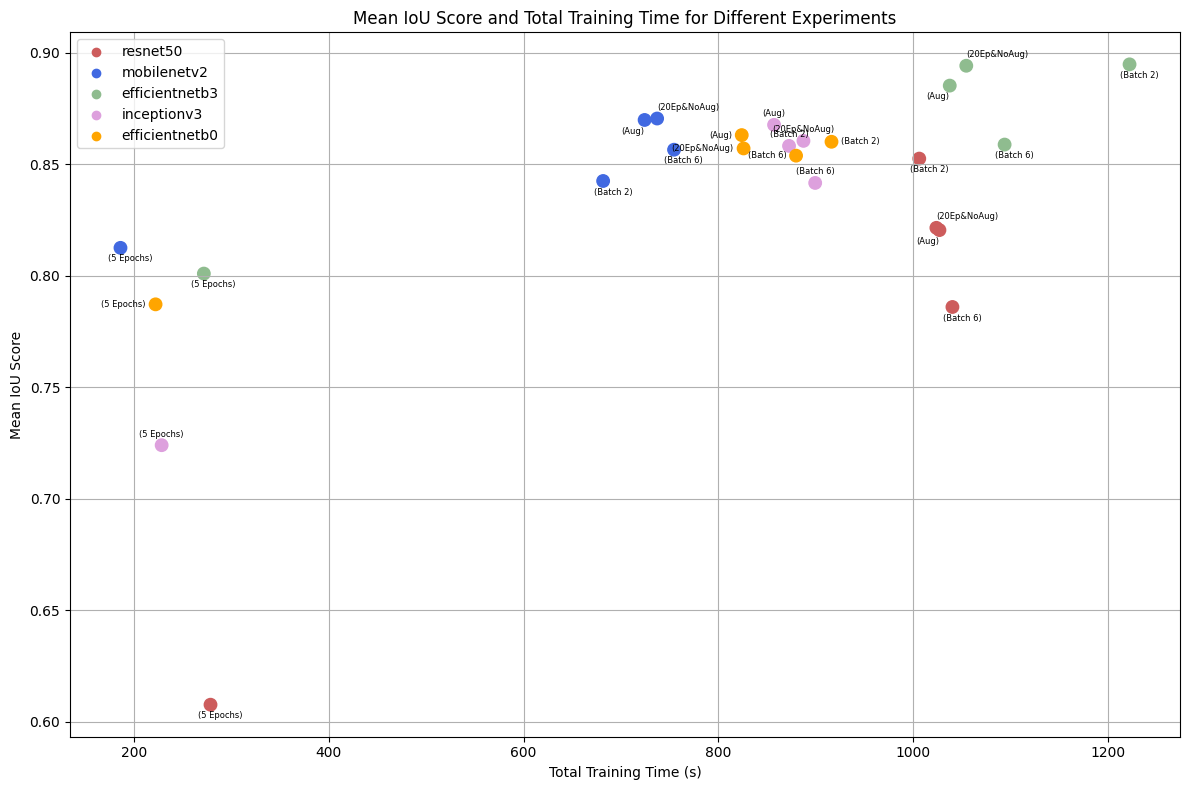

In [107]:
# Список экспериментов

experiments = [
    # resnet50
    "(20Ep&NoAug)",
    "(Aug)",
    "(5 Epochs)",
    "(Batch 6)",
    "(Batch 2)",
    # mobilenetv2
    "(20Ep&NoAug)",
    "(Aug)",
    "(5 Epochs)",
    "(Batch 6)",
    "(Batch 2)",
    # efficientnetb3
    "(20Ep&NoAug)",
    "(Aug)",
    "(5 Epochs)",
    "(Batch 6)",
    "(Batch 2)",
    # inceptionv3
    "(20Ep&NoAug)",
    "(Aug)",
    "(5 Epochs)",
    "(Batch 6)",
    "(Batch 2)",
    # efficientnetb0
    "(20Ep&NoAug)",
    "(Aug)",
    "(5 Epochs)",
    "(Batch 6)",
    "(Batch 2)",
]

mean_iou = [
    # resnet50
    0.821524, 0.820509, 0.607544, 0.786008, 0.852591,
    # mobilenetv2
    0.870571, 0.869925, 0.812544, 0.856576, 0.842541,
    # efficientnetb3
    0.894251, 0.885342, 0.800996, 0.858883, 0.894878,
    # inceptionv3
    0.860542, 0.867735, 0.723991, 0.841672, 0.85828,
    # efficientnetb0
    0.857151, 0.863133, 0.787191, 0.853909, 0.860141,
]

total_training_time = [
    # resnet50
    1023.77335, 1026.909135, 278.754095, 1040.247437, 1006.196861,
    # mobilenetv2
    737.14862, 724.302056, 186.347886, 754.517821, 681.734378,
    # efficientnetb3
    1054.459587, 1037.488147, 271.928467, 1093.793794, 1222.031492,
    # inceptionv3
    887.34134, 857.176518, 228.604505, 899.381351, 872.536155,
    # efficientnetb0
    825.877812, 823.999504, 222.365525, 879.754407, 916.123241,
]

# Цвета для разных моделей (5 точек на каждую модель)
colors = (
    ['indianred'] * 5 +
    ['royalblue'] * 5 +
    ['darkseagreen'] * 5 +
    ['plum'] * 5 +
    ['orange'] * 5
)

plt.figure(figsize=(12, 8))

# Рассеянный график
plt.scatter(total_training_time, mean_iou, c=colors, s=80)

# Добавляем подписи
for i, experiment in enumerate(experiments):
    x = total_training_time[i]
    y = mean_iou[i]

    # Если цвет 'plum' (розовый) — подпись сверху
    if colors[i] == 'plum':
        plt.text(
            x, y,
            experiment,
            fontsize=6,
            ha='center',
            va='bottom',
            position=(x, y + 0.003)
        )
    # Если цвет 'orange' (efficientnetb0)
    elif colors[i] == 'orange':
        # Для эксперимента "(Batch 2)" подпись справа, иначе — слева
        if experiment == "(Batch 2)":
            plt.text(
                x, y,
                experiment,
                fontsize=6,
                ha='left',      # подпись справа от точки
                va='center',
                position=(x + 10, y)  # смещение вправо
            )
        else:
            plt.text(
                x, y,
                experiment,
                fontsize=6,
                ha='right',     # подпись слева от точки
                va='center',
                position=(x - 10, y)  # смещение влево
            )
    else:
        # Для остальных экспериментов используем исходную логику
        if "(Aug)" in experiment:
            plt.text(
                x, y,
                experiment,
                fontsize=6,
                ha='right',
                va='top',
                position=(x, y - 0.003)
            )
        elif "(20Ep&NoAug)" in experiment:
            plt.text(
                x, y,
                experiment,
                fontsize=6,
                ha='left',
                va='bottom',
                position=(x, y + 0.003)
            )
        else:
            plt.text(
                x, y,
                experiment,
                fontsize=6,
                ha='center',
                va='center',
                position=(x + 10, y - 0.005)
            )

# Настройка осей и заголовка
plt.xlabel('Total Training Time (s)')
plt.ylabel('Mean IoU Score')
plt.title('Mean IoU Score and Total Training Time for Different Experiments')

# Увеличение границ графика
plt.margins(x=0.1, y=0.1)
min_time, max_time = min(total_training_time), max(total_training_time)
min_iou, max_iou = min(mean_iou), max(mean_iou)
plt.xlim(min_time - (max_time - min_time) * 0.05, 
         max_time + (max_time - min_time) * 0.05)
plt.ylim(min_iou - (max_iou - min_iou) * 0.05, 
         max_iou + (max_iou - min_iou) * 0.05)

# Сетка
plt.grid(True)

# Легенда
plt.scatter([], [], c='indianred', label='resnet50')
plt.scatter([], [], c='royalblue', label='mobilenetv2')
plt.scatter([], [], c='darkseagreen', label='efficientnetb3')
plt.scatter([], [], c='plum', label='inceptionv3')
plt.scatter([], [], c='orange', label='efficientnetb0')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

